# Revenue Modeling: Soda

**Purpose:** This notebook models soda tax revenue using a re-scaled baseline forecast to model the impact of COVID-19 and subsequent recovery. The methodology relies on the Prophet package and is similar to the analysis used in [this previous report](https://controller.phila.gov/philadelphia-audits/covid19-fiscal-impact-mar-2021/).


In [1]:
# Base imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from phila_style.matplotlib import get_theme
from phila_style import *
from phl_budget_data.clean import load_city_tax_collections

# Prophet
from fbprophet import Prophet

# fyp-analsis
from fyp_analysis.pipelines.modeling.predict import (
    aggregate_to_fiscal_year,
)
from fyp_analysis import SRC_DIR

2021-07-06 18:41:41,777 - fbprophet.plot - ERROR - Importing plotly failed. Interactive plots will not work.


/Users/nicholashand/miniconda3/envs/fyp/lib/python3.8/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping


In [2]:
pd.options.display.max_columns = 999

## Load the monthly data

This is monthly data pulled from the monthly Revenue Department reports.

In [3]:
soda_tax = (
    load_city_tax_collections()
    .query("name == 'soda' and kind=='total'")
    .query("total > 0")
    .set_index("date")
)

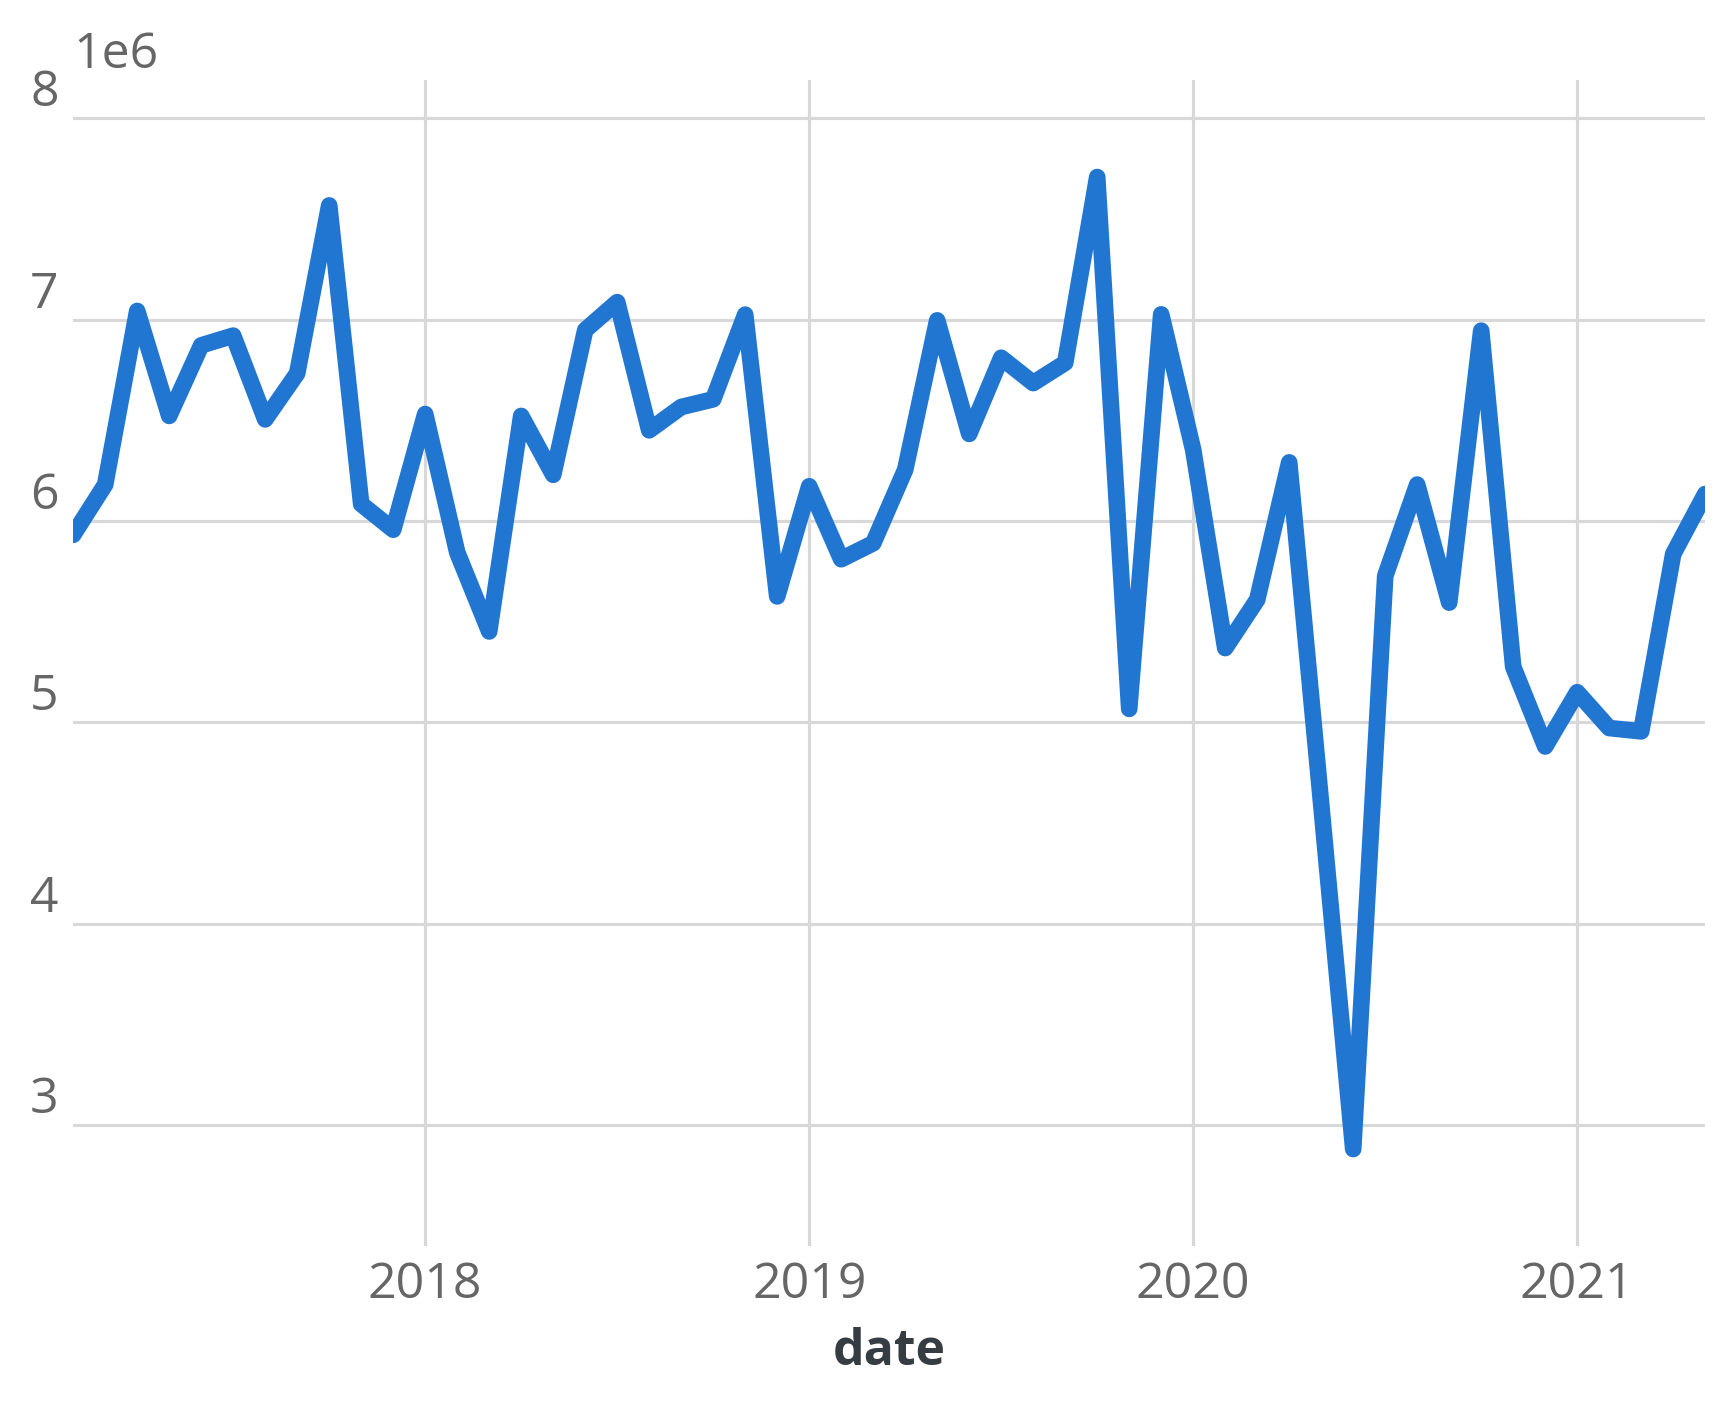

In [4]:
with plt.style.context(get_theme()):
    soda_tax.plot(y="total", legend=False)

## Model the baseline

Use Prophet to fit a baseline to the pre-COVID data.

In [5]:
df = (
    soda_tax["total"]
    .rename_axis("ds")
    .reset_index()
    .rename(columns={"total": "y"})
    .sort_values("ds")
)

In [6]:
fit_kwargs = {
    "daily_seasonality": False,
    "weekly_seasonality": False,
    "n_changepoints": min(int(0.7 * len(df)), 25),
    "seasonality_mode": "additive"
}

In [7]:
precovid = df.query("ds < '2020-04-01' and ds >= '2014-01-01'")

In [8]:
model = Prophet(**fit_kwargs)
model.fit(precovid);

/Users/nicholashand/miniconda3/envs/fyp/lib/python3.8/site-packages/fbprophet/forecaster.py:434: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.float)
/Users/nicholashand/miniconda3/envs/fyp/lib/python3.8/site-packages/fbprophet/forecaster.py:401: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details


Initial log joint probability = -49.3246
Iteration  1. Log joint probability =    38.8223. Improved by 88.147.
Iteration  2. Log joint probability =    62.6122. Improved by 23.7899.
Iteration  3. Log joint probability =    75.0022. Improved by 12.39.
Iteration  4. Log joint probability =    90.1026. Improved by 15.1003.
Iteration  5. Log joint probability =    100.879. Improved by 10.7768.
Iteration  6. Log joint probability =    103.694. Improved by 2.81463.
Iteration  7. Log joint probability =    103.698. Improved by 0.00369135.
Iteration  8. Log joint probability =    103.724. Improved by 0.026177.
Iteration  9. Log joint probability =     103.78. Improved by 0.0562141.
Iteration 10. Log joint probability =    103.877. Improved by 0.0972808.
Iteration 11. Log joint probability =    103.972. Improved by 0.0950049.
Iteration 12. Log joint probability =    104.197. Improved by 0.225122.
Iteration 13. Log joint probability =    104.207. Improved by 0.00987277.
Iteration 14. Log joint 

Make the future forecast through the end of the Plan:

In [9]:
# Get the forecast period
freq = "M"
forecast_stop_date = "2026-06-30"
periods = (
    pd.to_datetime(forecast_stop_date).to_period(freq) - df["ds"].max().to_period(freq)
).n
future = model.make_future_dataframe(periods=periods + 14, freq=f"{freq}S")

In [10]:
future.tail()

,ds
108,2026-02-01
109,2026-03-01
110,2026-04-01
111,2026-05-01
112,2026-06-01


Run the forecast:

In [11]:
# Forecast
forecast = model.predict(future)

/Users/nicholashand/miniconda3/envs/fyp/lib/python3.8/site-packages/fbprophet/forecaster.py:434: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.float)
/Users/nicholashand/miniconda3/envs/fyp/lib/python3.8/site-packages/fbprophet/forecaster.py:434: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.float)


Calculate fiscal year growth rates:

In [12]:
fy_forecast = aggregate_to_fiscal_year(forecast.set_index("ds")["yhat"], freq="MS")

In [13]:
growth_rates = 100 * (fy_forecast.diff() / fy_forecast.shift())

growth_rates

,yhat
fiscal_year,
2017,NaN
2018,143.516116
2019,-0.892322
2020,-0.741543
2021,-1.190293
2022,-0.911329
2023,-0.921359
2024,-0.770005
2025,-1.236537


## Generate a "no-growth" baseline

Repeat the pre-COVID data for each year in the forecast period

In [14]:
def project_flat_growth(X, start="2019-04", stop="2020-03"):
    """Normalize future growth to be flat at the last annual period."""
    # Make a copy first
    X = X.copy()
    freq = X.index.inferred_freq
    X.index.freq = freq

    # This is the part that will be projected
    norm = X.loc[start:stop].copy()
    latest_date = norm.index[-1]

    # This should be monthly or quarterly
    assert len(norm) in [4, 12]
    if len(norm) == 4:
        key = lambda dt: dt.quarter
    else:
        key = lambda dt: dt.month

    # Reset the index to months/quarters
    norm.index = [key(dt) for dt in norm.index]

    # Change the forecast to be flat
    forecast_start = latest_date + latest_date.freq
    Y = X.loc[forecast_start:].copy()

    # Reset index
    i = Y.index
    Y.index = [key(dt) for dt in Y.index]

    # Overwrite
    Y.loc[:] = norm.loc[Y.index].values
    Y.index = i

    # Add back to original
    X.loc[Y.index] = Y.values

    return X

In [15]:
forecast = (
    forecast[
        [
            "ds",
            "yhat",
            "yhat_lower",
            "yhat_upper",
            "yearly",
            "trend",
        ]
    ]
    .rename(
        columns={
            "ds": "date",
            "yhat": "total",
            "yhat_lower": "lower",
            "yhat_upper": "upper",
        }
    )
    .set_index("date")
)

In [16]:
flat_forecast = project_flat_growth(forecast)

## Examine recovery so far

Use the actual data to see how collections have responded since COVID

In [17]:
ratios = (soda_tax["total"] / flat_forecast["total"]).dropna()

In [18]:
ratios.loc["2020":]

date
2020-01-01    1.013751
2020-02-01    0.974817
2020-03-01    0.992833
2020-04-01    1.001195
2020-05-01    0.668343
2020-06-01    0.439891
2020-07-01    0.834537
2020-08-01    0.939192
2020-09-01    0.842377
2020-10-01    0.953649
2020-11-01    0.961977
2020-12-01    0.728574
2021-01-01    0.821678
2021-02-01    0.902716
2021-03-01    0.877017
2021-04-01    0.928768
2021-05-01    0.892715
Freq: MS, Name: total, dtype: float64

## Set up future recovery

**Assumptions**

- A two-year recovery period
- After this period, growth rates is assumed to be -1%
- Permanent loss of 1% to the overall base

Set up the monthly dates for the two different forecast periods:

In [19]:
future_dates_1 = pd.date_range("2021-07-01", "2023-06-30", freq="MS")
future_dates_2 = pd.date_range("2023-07-01", "2026-06-30", freq="MS")

In [20]:
LIMIT = 0.99

In [21]:
future_ratios_1 = pd.Series(
    [0.9] * 3 + [0.925] * 3 + [0.95] * 6 + [0.97] * 6 + [LIMIT] * 6,
    index=future_dates_1,
)
future_ratios_2 = pd.Series(
    [LIMIT * 0.99] * 12 + [LIMIT * 0.99 ** 2] * 12 + [LIMIT * 0.99 ** 3] * 12,
    index=future_dates_2,
)

Plot the recovery:

<AxesSubplot:>

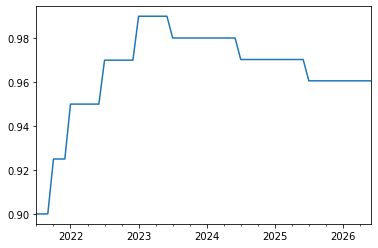

In [22]:
pd.concat([future_ratios_1, future_ratios_2]).plot()

Calculate the final forecast by re-scaling the flat forecast with our future ratios:

In [23]:
# Get the baseline forecast
F = flat_forecast["total"].copy()
actuals = df.set_index("ds")["y"]
F = pd.concat([F.loc["2021-07-01":], actuals])

# 2-year recovery period
inter = F.index.intersection(future_ratios_1.index)
F.loc[inter] *= future_ratios_1.loc[inter].values

# -1% growth rate period
inter = F.index.intersection(future_ratios_2.index)
F.loc[inter] *= future_ratios_2.loc[inter].values

The final fiscal year forecast:

In [24]:
FORECAST = aggregate_to_fiscal_year(F, freq="MS").squeeze()

In [25]:
FORECAST/1e6

fiscal_year
2017    32.549118
2018    77.290439
2019    76.911933
2020    71.176006
2021    61.647518
2022    71.350159
2023    75.116987
2024    75.148875
2025    74.397386
2026    73.653412
Name: 0, dtype: float64

Growth rates:

In [26]:
(FORECAST.diff() / FORECAST.shift()).dropna()

fiscal_year
2018    1.374579
2019   -0.004897
2020   -0.074578
2021   -0.133872
2022    0.157389
2023    0.052794
2024    0.000425
2025   -0.010000
2026   -0.010000
Name: 0, dtype: float64

## Compare to Five Year Plan and save

Five Year Plan numbers from Adopted FY22-FY26 Plan:

In [27]:
FYP = pd.Series(
    [72515000, 76888000, 76311000, 75739000, 75171000],
    index=pd.Index(range(2022, 2022 + 5), name="fiscal_year"),
)

In [28]:
FY21_ESTIMATE = 63013000 # From Adopted Plan

In [29]:
def get_final_dataframe(forecast, budget):
    final = pd.concat(
        [forecast.rename("Controller"), budget.rename("Five Year Plan")], axis=1
    )

    final.loc[2021, :] = FY21_ESTIMATE
    final["Five Year Plan"] = final["Five Year Plan"].fillna(final["Controller"])

    return final

In [30]:
final = get_final_dataframe(FORECAST, FYP)

In [31]:
final.head()

,Controller,Five Year Plan
fiscal_year,,
2017,32549118.0,32549118.0
2018,77290439.0,77290439.0
2019,76911933.0,76911933.0
2020,71176006.0,71176006.0
2021,63013000.0,63013000.0


Save the result:

In [32]:
final.to_excel(SRC_DIR / ".." / ".." / "data" / "06_model_output" / "soda-forecast.xlsx")

Plot:

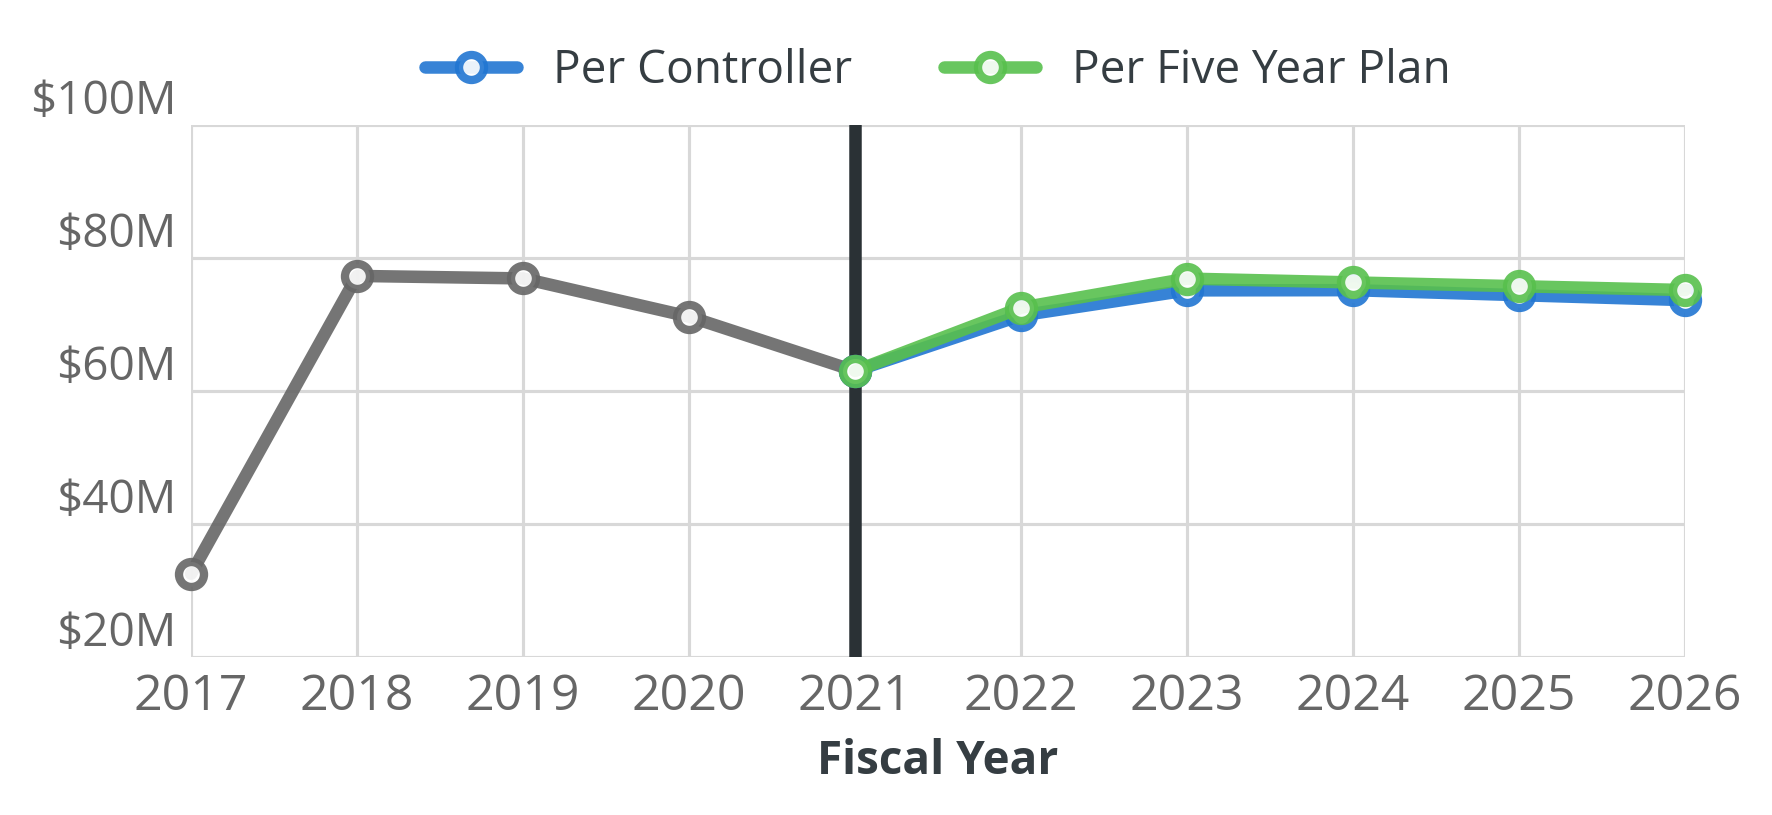

In [33]:
comparison = final.copy()

# Put into millions
for col in comparison:
    comparison[col] /= 1e6

# Columns
col = "Controller"

plan_start_year = 2022
start_year = 2017

# Plot
with plt.style.context(get_theme()):

    fig, ax = plt.subplots(
        figsize=(6, 2.5), gridspec_kw=dict(bottom=0.17, left=0.12, top=0.88, right=0.95)
    )

    colors = get_default_palette()
    kws = dict(
        lw=3,
        mew=2,
        alpha=0.9,
    )

    # Plot vertical line
    this_year = plan_start_year - 1
    ax.axvline(x=this_year, c=colors["dark-grey"], lw=3)

    # Plot historic
    color = colors["medium-grey"]
    comparison[col].loc[start_year:this_year].plot(
        ax=ax,
        marker="o",
        color=color,
        mec=color,
        mfc="white",
        label="",
        clip_on=False,
        **kws,
    )

    F = comparison.loc[this_year:].copy()

    # Plot Controller
    color = colors["blue"]
    F["Controller"].plot(
        ax=ax,
        marker="o",
        color=color,
        mec=color,
        mfc="white",
        label="Per Controller",
        clip_on=False,
        **kws,
    )

    # Plot Mayor
    color = colors["green"]
    F["Five Year Plan"].plot(
        ax=ax,
        marker="o",
        color=color,
        mec=color,
        mfc="white",
        label="Per Five Year Plan",
        clip_on=False,
        **kws,
    )

    ax.set_xlabel("Fiscal Year", fontsize=11)
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels([f"${x:,.0f}M" for x in ax.get_yticks()], fontsize=11)

    ax.set_xlim(start_year, plan_start_year + 4)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels([f"{x:.0f}" for x in ax.get_xticks()])

    ax.legend(
        loc="lower center",
        bbox_transform=ax.transAxes,
        bbox_to_anchor=(0.5, 0.98),
        ncol=2,
        fontsize=11,
    )

    plt.savefig(
        SRC_DIR
        / ".."
        / ".."
        / "data"
        / "06_model_output"
        / "forecast_figures"
        / "Soda.png"
    )